In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
# Phase 1 – Load and merge data

data_dir = Path("../data")  # change if needed

hr = pd.read_csv(data_dir / "heart_rate_7users_overtrained_full.csv")
steps = pd.read_csv(data_dir / "steps_7users_overtrained_full.csv")

print("Heart-rate shape:", hr.shape)
print("Steps shape     :", steps.shape)

# Convert dates
hr["calendar_date"] = pd.to_datetime(hr["calendar_date"])
steps["calendar_date"] = pd.to_datetime(steps["calendar_date"])

# Merge on user + date
data = pd.merge(
    hr,
    steps[["sdv_user_id", "calendar_date", "steps", "steps_goal"]],
    on=["sdv_user_id", "calendar_date"],
    how="inner"
)

print("Merged shape:", data.shape)
print(data[["sdv_user_id","calendar_date","steps",
            "average_stress_level",
            "resting_heart_rate_in_beats_per_minute"]].head())


Heart-rate shape: (2555, 11)
Steps shape     : (2555, 11)
Merged shape: (2555, 13)
   sdv_user_id calendar_date  steps  average_stress_level  \
0         8101    2025-01-01   9245                  26.0   
1         8101    2025-02-01  19145                  37.0   
2         8101    2025-03-01  11281                  30.0   
3         8101    2025-04-01  12143                  32.0   
4         8101    2025-05-01  13651                  25.0   

   resting_heart_rate_in_beats_per_minute  
0                                    59.0  
1                                    59.0  
2                                    58.0  
3                                    57.0  
4                                    57.0  


In [3]:
# Phase 2 – Map sdv_user_id -> activity_label (5 classes)

persona_map = {
    8101: "high_workout",
    8102: "high_workout",
    8103: "healthy",
    8104: "healthy",
    8105: "low_activity",
    8106: "lazy_obese",
    8107: "over_trained",   
}

data["activity_label"] = data["sdv_user_id"].map(persona_map)

print("Label distribution:")
print(data["activity_label"].value_counts())


Label distribution:
activity_label
high_workout    730
healthy         730
low_activity    365
lazy_obese      365
over_trained    365
Name: count, dtype: int64


In [4]:
# Phase 3.1 – Encode label

from sklearn.preprocessing import LabelEncoder

feature_cols = [
    "steps",
    "average_stress_level",
    "resting_heart_rate_in_beats_per_minute",
]

X = data[feature_cols].copy()
y_str = data["activity_label"].copy()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_str)

class_names = label_encoder.classes_
print("Classes:", class_names)
print("Encoded labels:", np.unique(y))


Classes: ['healthy' 'high_workout' 'lazy_obese' 'low_activity' 'over_trained']
Encoded labels: [0 1 2 3 4]


In [5]:
# Phase 3.2 – Train / Validation split

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Val shape  :", X_val.shape)


Train shape: (2044, 3)
Val shape  : (511, 3)


In [6]:
# Phase 3.3 – Scale features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

print("First 3 scaled rows:\n", X_train_scaled[:3])


First 3 scaled rows:
 [[-0.045477    0.69275435  0.73744307]
 [-0.59649105 -0.8815552  -0.22877121]
 [-0.2238186  -0.50076419 -0.1306428 ]]


In [7]:
# Phase 4.1 – Reshape data for 1D CNN

# 3 features -> shape (batch, 3, 1)
X_train_cnn = X_train_scaled.reshape(-1, 3, 1).astype("float32")
X_val_cnn   = X_val_scaled.reshape(-1, 3, 1).astype("float32")

y_train_cnn = y_train.astype("int32")
y_val_cnn   = y_val.astype("int32")

print("X_train_cnn shape:", X_train_cnn.shape)
print("X_val_cnn shape  :", X_val_cnn.shape)


X_train_cnn shape: (2044, 3, 1)
X_val_cnn shape  : (511, 3, 1)


In [8]:
# Phase 4.2 – Define CNN model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (3, 1)
num_classes = len(class_names)

model = Sequential([
    Conv1D(filters=32, kernel_size=2, activation="relu", input_shape=input_shape),
    Conv1D(filters=64, kernel_size=2, activation="relu"),
    GlobalAveragePooling1D(),
    Dense(16, activation="relu"),
    Dropout(0.2),
    Dense(num_classes, activation="softmax"),  # 5-class output
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             96        
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 85        
                                                        

In [9]:
# Phase 5.1 – Compile model

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


In [10]:
# Phase 5.2 – Train model

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

history = model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_val_cnn, y_val_cnn),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1,
)


Epoch 1/50
32/32 [==============================] - 2s 19ms/step - loss: 1.4414 - accuracy: 0.5230 - val_loss: 1.2476 - val_accuracy: 0.6360
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 1.0825 - accuracy: 0.6659 - val_loss: 0.8080 - val_accuracy: 0.7769
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.7266 - accuracy: 0.7559 - val_loss: 0.5180 - val_accuracy: 0.8337
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.5735 - accuracy: 0.7784 - val_loss: 0.4209 - val_accuracy: 0.8493
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.5064 - accuracy: 0.8038 - val_loss: 0.3646 - val_accuracy: 0.8669
Epoch 6/50
32/32 [==============================] - 0s 7ms/step - loss: 0.4590 - accuracy: 0.8214 - val_loss: 0.3182 - val_accuracy: 0.8885
Epoch 7/50
32/32 [==============================] - 0s 7ms/step - loss: 0.4157 - accuracy: 0.8293 - val_loss: 0.2962 - val_accuracy: 0.8885
Epoch 8/50
32/32 [=

In [27]:
# Save model + scaler + label encoder

#Keras model
model.save("activity_cnn_5classes.h5")

#Scaler + label encoder
import joblib

joblib.dump(scaler, "scaler_activity.pkl")
joblib.dump(label_encoder, "label_encoder_activity.pkl")

print("Saved: activity_cnn_5classes.h5, scaler_activity.pkl, label_encoder_activity.pkl")


Saved: activity_cnn_5classes.h5, scaler_activity.pkl, label_encoder_activity.pkl


c:\INHOLLAND UNIVERSITY\Internship Third Year\Project\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


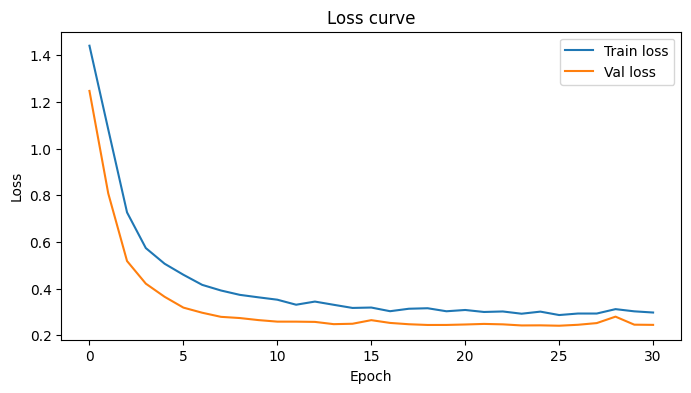

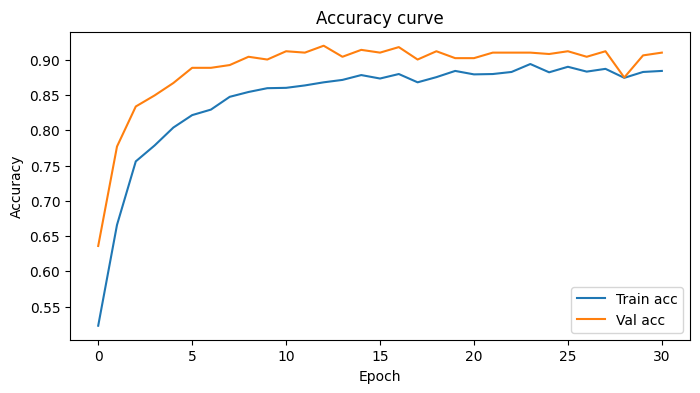

In [11]:
import matplotlib.pyplot as plt

hist = history.history

plt.figure(figsize=(8,4))
plt.plot(hist["loss"], label="Train loss")
plt.plot(hist["val_loss"], label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.title("Loss curve")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(hist["accuracy"], label="Train acc")
plt.plot(hist["val_accuracy"], label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.title("Accuracy curve")
plt.show()


In [12]:
# Phase 6.1 – Overall validation accuracy

from sklearn.metrics import accuracy_score

y_val_probs = model.predict(X_val_cnn)
y_val_pred  = np.argmax(y_val_probs, axis=1)

val_acc = accuracy_score(y_val_cnn, y_val_pred)
print("Validation accuracy:", val_acc)


16/16 [==============================] - 0s 2ms/step
Validation accuracy: 0.9119373776908023



Classification report:

              precision    recall  f1-score   support

     healthy       0.88      0.94      0.91       146
high_workout       0.96      0.92      0.94       146
  lazy_obese       0.88      0.89      0.88        73
low_activity       0.85      0.79      0.82        73
over_trained       0.97      0.97      0.97        73

    accuracy                           0.91       511
   macro avg       0.91      0.90      0.91       511
weighted avg       0.91      0.91      0.91       511



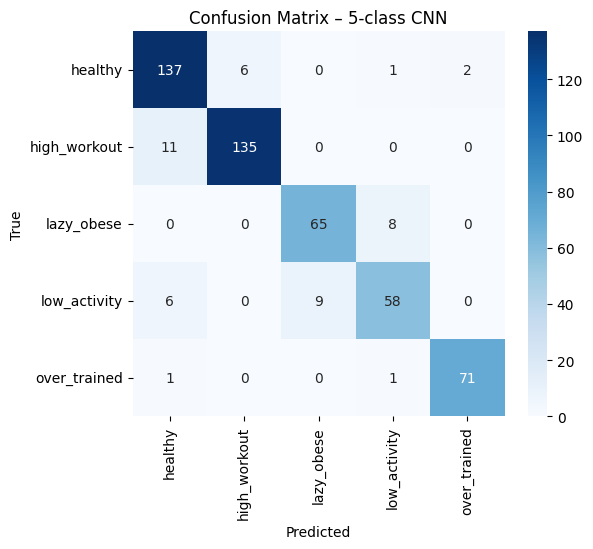

In [13]:
# Phase 6.2 – Confusion matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val_cnn, y_val_pred)

print("\nClassification report:\n")
print(classification_report(y_val_cnn, y_val_pred, target_names=class_names))

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – 5-class CNN")
plt.show()


In [14]:
# Phase 7.1 – Predict for one row (one day)

def predict_activity_for_row_keras(row, model, scaler, label_encoder, feature_cols):
    # row: pandas Series with at least the three feature columns
    x = row[feature_cols].to_numpy().astype("float32").reshape(1, -1)
    x_scaled = scaler.transform(x)
    x_cnn = x_scaled.reshape(1, 3, 1)

    probs = model.predict(x_cnn, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_label = label_encoder.inverse_transform([pred_idx])[0]
    return pred_label, probs


In [15]:
# Phase 7.2 – Generate feedback text

def generate_feedback(row, predicted_label, probs):
    steps  = row["steps"]
    stress = row["average_stress_level"]
    rest   = row["resting_heart_rate_in_beats_per_minute"]
    conf   = float(np.max(probs)) * 100

    summary = (
        f"Today: {steps:.0f} steps, "
        f"stress {stress:.1f}, "
        f"resting HR {rest:.1f} bpm.\n\n"
    )

    if predicted_label == "over_trained":
        msg = (
            "Very high training load with high stress and elevated resting heart rate. "
            "Your body may not be fully recovering. Consider an easier day, more sleep, "
            "and focus on recovery."
        )
    elif predicted_label == "high_workout":
        msg = (
            "You are highly active. This is good for fitness, but remember to include rest days "
            "and listen to signals of fatigue."
        )
    elif predicted_label == "healthy":
        msg = (
            "Balanced profile. Your activity, stress and heart rate look healthy. "
            "Try to keep this pattern steady across the week."
        )
    elif predicted_label == "low_activity":
        msg = (
            "Your stress and resting heart rate are okay, but your activity is a bit low today. "
            "Even 10–20 minutes of walking or light exercise will help."
        )
    else:  # lazy_obese
        msg = (
            "Low activity and relatively high resting heart rate. "
            "Start with small daily movement goals (for example +1500 steps), "
            "and increase slowly over time."
        )

    return summary + msg + f"\n\nModel confidence for '{predicted_label}': {conf:.1f}%."


In [16]:
# Example: test on a random over_trained day

sample_row = data[data["activity_label"] == "over_trained"].sample(1, random_state=0).iloc[0]

pred_label, probs = predict_activity_for_row_keras(
    sample_row, model, scaler, label_encoder, feature_cols
)

print("True label     :", sample_row["activity_label"])
print("Predicted label:", pred_label)
print("\n--- FEEDBACK ---\n")
print(generate_feedback(sample_row, pred_label, probs))


True label     : over_trained
Predicted label: over_trained

--- FEEDBACK ---

Today: 18963 steps, stress 60.5, resting HR 75.2 bpm.

Very high training load with high stress and elevated resting heart rate. Your body may not be fully recovering. Consider an easier day, more sleep, and focus on recovery.

Model confidence for 'over_trained': 100.0%.


c:\INHOLLAND UNIVERSITY\Internship Third Year\Project\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [17]:
def test_manual_values(steps, stress, rest_hr):
    row = pd.Series({
        "steps": steps,
        "average_stress_level": stress,
        "resting_heart_rate_in_beats_per_minute": rest_hr,
    })

    pred_label, probs = predict_activity_for_row_keras(
        row, model, scaler, label_encoder, feature_cols
    )

    print("Predicted label:", pred_label)
    print("Probabilities :", np.round(probs, 3))
    print("\n--- FEEDBACK ---\n")
    print(generate_feedback(row, pred_label, probs))



In [28]:
test_manual_values(20000, 60, 80)





Predicted label: over_trained
Probabilities : [0. 0. 0. 0. 1.]

--- FEEDBACK ---

Today: 20000 steps, stress 60.0, resting HR 80.0 bpm.

Very high training load with high stress and elevated resting heart rate. Your body may not be fully recovering. Consider an easier day, more sleep, and focus on recovery.

Model confidence for 'over_trained': 100.0%.


c:\INHOLLAND UNIVERSITY\Internship Third Year\Project\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
